# Analysis of MIGHT posteriors and its calibration

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import auc, roc_curve
from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_oob_forest

In [140]:
def make_trunk_classification(
    n_samples,
    n_dim=4096,
    n_informative=1,
    simulation: str = "trunk",
    mu_0: float = 0,
    mu_1: float = 1,
    rho: int = 0,
    band_type: str = "ma",
    return_params: bool = False,
    mix: float = 0.5,
    seed=None,
):
    if n_dim < n_informative:
        raise ValueError(
            f"Number of informative dimensions {n_informative} must be less than number "
            f"of dimensions, {n_dim}"
        )
    rng = np.random.default_rng(seed=seed)

    mu_0 = np.array([mu_0 / np.sqrt(i) for i in range(1, n_informative + 1)])
    mu_1 = np.array([mu_1 / np.sqrt(i) for i in range(1, n_informative + 1)])

    if rho != 0:
        if band_type == "ma":
            cov = _moving_avg_cov(n_informative, rho)
        elif band_type == "ar":
            cov = _autoregressive_cov(n_informative, rho)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov = np.identity(n_informative)

    if mix < 0 or mix > 1:
        raise ValueError("Mix must be between 0 and 1.")

    # speed up computations for large multivariate normal matrix with SVD approximation
    if n_informative > 1000:
        method = "cholesky"
    else:
        method = "svd"

    if simulation == "trunk":
        X = np.vstack(
            (
                rng.multivariate_normal(mu_0, cov, n_samples // 2, method=method),
                rng.multivariate_normal(mu_1, cov, n_samples // 2, method=method),
            )
        )
    elif simulation == "trunk_overlap":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.array(
            [
                rng.multivariate_normal(*(norm_params[i]), method=method)
                for i in mixture_idx
            ]
        ).squeeze()
        X_mixture_2 = np.array(
            [
                rng.multivariate_normal(*(norm_params[i]), method=method)
                for i in mixture_idx
            ]
        ).squeeze()
        X = np.vstack(
            (
                X_mixture_2.reshape(n_samples // 2, n_informative),
                X_mixture.reshape(n_samples // 2, n_informative),
            )
        )
    elif simulation == "trunk_mix":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=float,
        )

        X = np.vstack(
            (
                rng.multivariate_normal(
                    np.zeros(n_informative), cov, n_samples // 2, method=method
                ),
                X_mixture.reshape(n_samples // 2, n_informative),
            )
        )
    else:
        raise ValueError(f"Simulation must be: trunk, trunk_overlap, trunk_mix")

    if n_dim > n_informative:
        X = np.hstack(
            (X, rng.normal(loc=0, scale=1, size=(X.shape[0], n_dim - n_informative)))
        )

    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    if return_params:
        returns = [X, y]
        if simulation == "trunk":
            returns += [[mu_0, mu_1], [cov, cov]]
        elif simulation == "trunk-overlap":
            returns += [[np.zeros(n_informative), np.zeros(n_informative)], [cov, cov]]
        elif simulation == "trunk-mix":
            returns += [*list(zip(*norm_params)), X_mixture]
        return returns
    return X, y

In [141]:
seed = 100

In [152]:
X, y = make_trunk_classification(
    n_samples=256,
    n_dim=4096,
    simulation="trunk_overlap",
    mu_0=0,
    mu_1=5,
    mix=0.75,
    n_informative=1,
    seed=seed,
)
print(X.shape, y.shape)

(256, 4096) (256,)


In [161]:
est = HonestForestClassifier(
    n_estimators=6000,
    max_samples=0.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    n_jobs=-1,
    honest_prior="ignore",
    random_state=seed,
)
# est.fit(X, y)
est, observe_proba = build_oob_forest(est, X, y)

In [144]:
structure_samples = est.structure_indices_
leaf_samples = est.honest_indices_
oob_samples = est.oob_samples_
for tree_idx in range(est.n_estimators):
    assert len(structure_samples[tree_idx]) + len(leaf_samples[tree_idx]) + len(
        oob_samples[tree_idx]
    ) == len(
        y
    ), f"{tree_idx} {len(structure_samples[tree_idx])} {len(leaf_samples[tree_idx])} {len(y)}"

In [154]:
# compute the balance for each tree
ratios = []
oob_samples = est.oob_samples_
nan_counts = np.zeros(y.shape)
for tree_idx in range(est.n_estimators):
    tree_oob_idx = oob_samples[tree_idx]
    tree_predictions = est.estimators_[tree_idx].predict_proba(X[tree_oob_idx, :])
    if np.isnan(tree_predictions[:, 0]).any():
        # print(tree_idx)
        # print(tree_predictions)
        nan_counts[tree_oob_idx[np.isnan(tree_predictions[:, 0])]] += 1
        # print(nan_counts)
        # break
    ratio = np.sum(y[tree_oob_idx]) / len(tree_oob_idx)
    ratios.append(ratio)

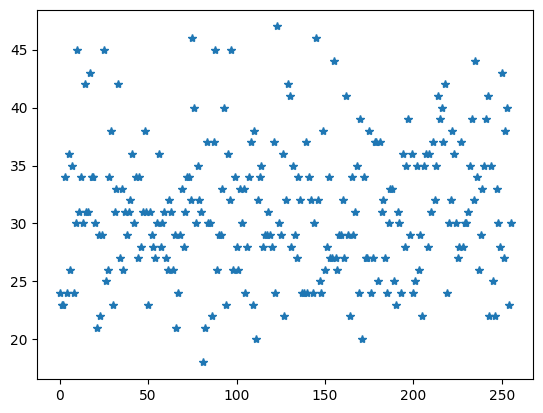

In [155]:
plt.plot(nan_counts, "*")

<Axes: ylabel='Count'>

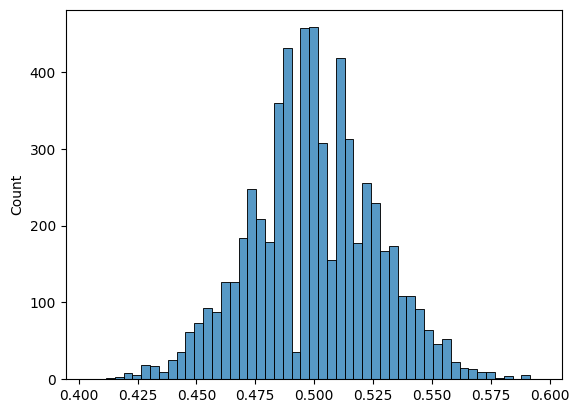

In [156]:
fig, ax = plt.subplots()
sns.histplot(ratios, ax=ax)

In [71]:
posteriors = np.empty(observe_proba.shape[:2])
for i in range(observe_proba.shape[0]):
    for j in range(observe_proba.shape[1]):
        try:
            posteriors[i, j] = np.nanargmax(observe_proba[i, j, :])
        except ValueError:
            posteriors[i, j] = np.nan

print(posteriors.shape)
posteriors = np.nansum(posteriors, axis=0) / posteriors.shape[0]

(6000, 256)


In [162]:
posteriors = np.nanmean(observe_proba, axis=0)[:, 1]
print(posteriors.shape)

(256,)


In [163]:
print(np.isnan(posteriors).sum())

0


In [164]:
fpr, tpr, _ = roc_curve(y, posteriors)

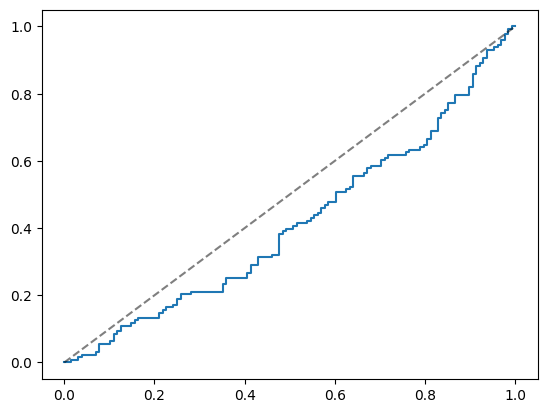

In [165]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)
# fig.savefig("/Users/adam2392/Downloads/10xdata-ignore-stratify-hardvote.png")

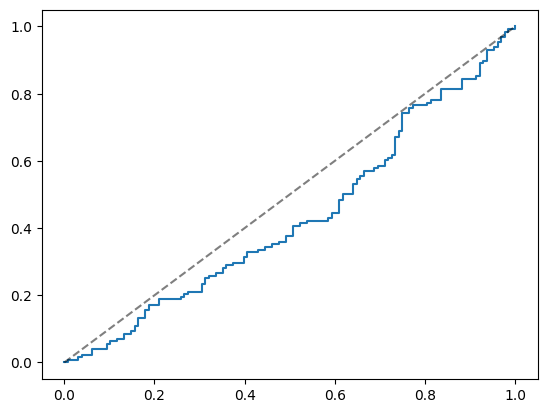

In [160]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)
# fig.savefig("/Users/adam2392/Downloads/10xdata-ignore-stratify-hardvote.png")

# Empirical prior

In [17]:
# compute the balance for each tree
ratios = []
oob_samples = est.oob_samples_
for tree_idx in range(est.n_estimators):
    tree_oob_idx = oob_samples[tree_idx]
    tree_predictions = est.estimators_[tree_idx].predict_proba(X[tree_oob_idx, :])
    print(tree_predictions)
    break
    ratio = np.sum(y[tree_oob_idx]) / len(tree_oob_idx)
    ratios.append(ratio)

[[0.375      0.625     ]
 [0.375      0.625     ]
 [0.53333333 0.46666667]
 [0.52941176 0.47058824]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.52941176 0.47058824]
 [0.83333333 0.16666667]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.52941176 0.47058824]
 [0.375      0.625     ]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.52941176 0.47058824]
 [0.53333333 0.46666667]
 [0.33333333 0.66666667]
 [0.375      0.625     ]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.52941176 0.47058824]
 [0.5        0.5       ]
 [0.53333333 0.46666667]
 [0.5        0.5       ]
 [0.375      0.625     ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.28571429 0.71428571]
 [0.52941176 0.47058824]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.52941176 0.47058824]
 [0.52941176 0.47058824]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]
 [0.53333333 0.46666667]


<Axes: ylabel='Count'>

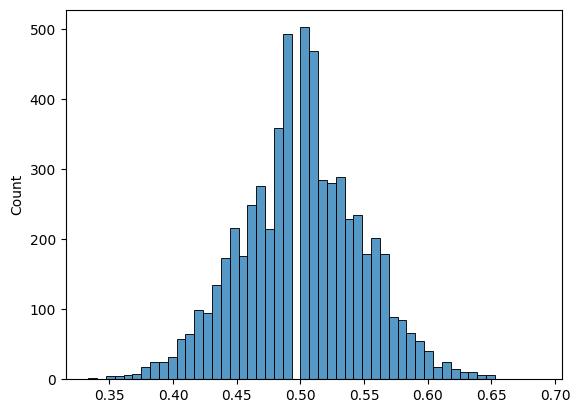

In [6]:
fig, ax = plt.subplots()
sns.histplot(ratios, ax=ax)

In [14]:
posteriors = np.nanmean(observe_proba, axis=0)[:, 1]
print(posteriors.shape)

(256,)


In [10]:
posteriors = np.empty(observe_proba.shape[:2])
for i in range(observe_proba.shape[0]):
    for j in range(observe_proba.shape[1]):
        try:
            posteriors[i, j] = np.nanargmax(observe_proba[i, j, :])
        except ValueError:
            posteriors[i, j] = np.nan

print(posteriors.shape)
posteriors = np.nansum(posteriors, axis=0) / posteriors.shape[0]

(6000, 256)


In [15]:
fpr, tpr, _ = roc_curve(y, posteriors)

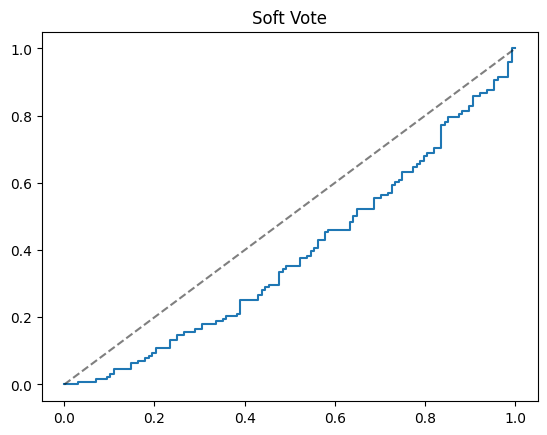

In [16]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)
ax.set_title("Soft Vote")
fig.savefig("/Users/adam2392/Downloads/empirical-stratify-softvote.png")

# Over many seeds

In [173]:
X, y = make_trunk_classification(
    n_samples=256,
    n_dim=4096,
    simulation="trunk_mix",
    mu_0=0,
    mu_1=5,
    mix=0.75,
    n_informative=1,
    seed=seed,
)
print(y.shape)
print(y)

(256,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_78381/255775868.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_mixture = np.fromiter(


In [177]:
print([len(x) for x in est.estimators_samples_])

[205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205,

/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_78381/255775868.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_mixture = np.fromiter(
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_78381/255775868.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_mixture = np.fromiter(
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_78381/255775868.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_mixture = np.fromiter(
/var/folde

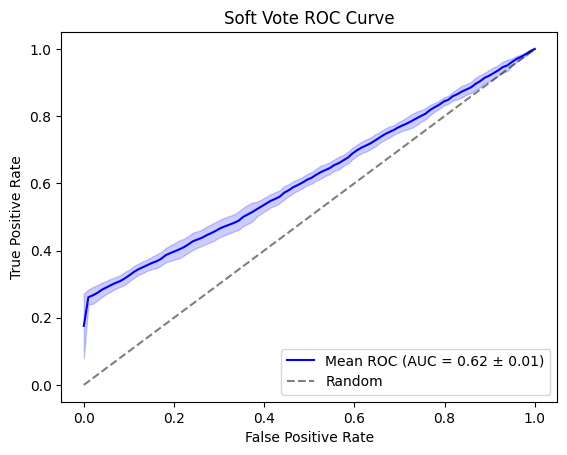

In [176]:
# Initialize lists to store the FPRs, TPRs, and AUCs for each iteration
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for seed in range(10):
    X, y = make_trunk_classification(
        n_samples=1024,
        n_dim=4096,
        simulation="trunk_mix",
        mu_0=0,
        mu_1=5,
        mix=0.75,
        n_informative=1,
        seed=seed,
    )

    est = HonestForestClassifier(
        n_estimators=6000,
        max_samples=0.2,
        max_features=0.3,
        bootstrap=True,
        stratify=True,
        n_jobs=-1,
        honest_prior="empirical",
        random_state=seed,
    )
    est, observe_proba = build_oob_forest(est, X, y)

    posteriors = np.nanmean(observe_proba, axis=0)[:, 1]
    # posteriors = np.empty(observe_proba.shape[:2])
    # for i in range(observe_proba.shape[0]):
    #     for j in range(observe_proba.shape[1]):
    #         try:
    #             posteriors[i, j] = np.nanargmax(observe_proba[i, j, :])
    #         except ValueError:
    #             posteriors[i, j] = np.nan
    # print(posteriors.shape)
    # posteriors = np.nansum(posteriors, axis=0) / posteriors.shape[0]

    fpr, tpr, _ = roc_curve(y, posteriors)

    # Interpolate the TPR values for the common mean FPR points
    tpr_interpolated = np.interp(mean_fpr, fpr, tpr)
    tprs.append(tpr_interpolated)

    # Compute the AUC for this iteration
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

# Calculate the mean and standard deviation of the TPRs and AUCs
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

# Plot the mean ROC curve with shaded area for standard deviation
fig, ax = plt.subplots()
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)
ax.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color="b", alpha=0.2)

ax.plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)
ax.set_title("Soft Vote ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
fig.savefig(
    "/Users/adam2392/Downloads/trunkmix1024samples-empirical-stratify-softvote-maxsamples.png"
)

# Test on held-out dataset

In [88]:
X, y = make_trunk_classification(
    n_samples=256,
    n_dim=4096,
    simulation="trunk_overlap",
    mu_0=0,
    mu_1=5,
    mix=0.75,
    n_informative=1,
    seed=seed,
)
print(X.shape, y.shape)

(256, 4096) (256,)


/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_78381/1239434664.py:60: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, n_informative)),
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_78381/1239434664.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_mixture = np.fromiter(
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_78381/1239434664.py:67: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype=np.dtype((float, n_informative)),
/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_78381/1239434664.py:62: DeprecationW

In [89]:
est = HonestForestClassifier(
    n_estimators=6000,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    n_jobs=-1,
    honest_prior="ignore",
    random_state=seed,
)
est.fit(X, y)
# est, observe_proba = build_oob_forest(est, X, y)

HonestForestClassifier(honest_prior='ignore', max_features=0.3, max_samples=1.6,
                       n_estimators=6000, n_jobs=-1, random_state=100,
                       stratify=True)

In [133]:
import threading

from joblib import Parallel, delayed
from numpy.typing import ArrayLike
from sklearn.base import clone
from sklearn.ensemble._base import _partition_estimators
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.multiclass import type_of_target
from sktree.stats.forestht import _parallel_predict_proba, _parallel_predict_proba_oob

X_test, y_test = make_trunk_classification(
    n_samples=100,
    n_dim=4096,
    simulation="trunk_overlap",
    mu_0=0,
    mu_1=5,
    mix=0.75,
    n_informative=1,
    seed=seed + 2,
)
print(X_test.shape, y_test.shape)

(100, 4096) (100,)


In [134]:
# Assign chunk of trees to jobs
X_test = est._validate_X_predict(X_test)
verbose = False
n_jobs, _, _ = _partition_estimators(est.n_estimators, est.n_jobs)

# avoid storing the output of every estimator by summing them here
lock = threading.Lock()
# accumulate the predictions across all trees
all_proba = est.predict_proba_per_tree(X_test)

In [135]:
observe_proba = all_proba
print(observe_proba.shape)

(6000, 100, 2)


In [136]:
# compute the balance for each tree
ratios = []
nan_counts = np.zeros(y_test.shape)
for tree_idx in range(est.n_estimators):
    tree_predictions = est.estimators_[tree_idx].predict_proba(X_test)
    if np.isnan(tree_predictions[:, 0]).any():
        # print(tree_idx)
        # print(tree_predictions)
        nan_counts[np.isnan(tree_predictions[:, 0])] += 1
        # print(nan_counts)
        # break
    ratio = np.sum(y_test) / len(tree_oob_idx)
    ratios.append(ratio)

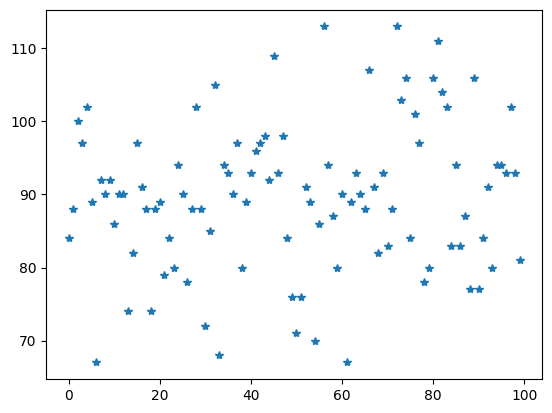

In [137]:
plt.plot(nan_counts, "*")

(100,)


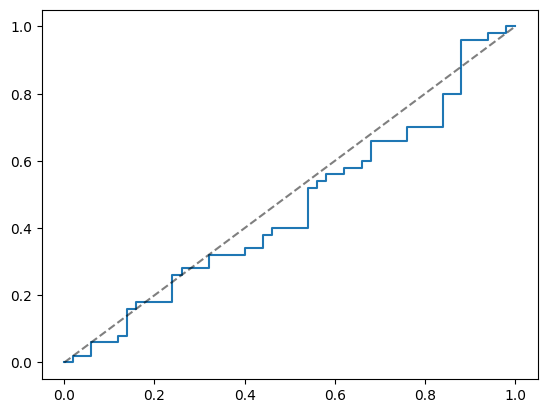

In [139]:
posteriors = np.nanmean(observe_proba, axis=0)[:, 1]
print(posteriors.shape)
fpr, tpr, _ = roc_curve(y_test, posteriors)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "k--", label="Random", alpha=0.5)
fig.savefig("/Users/adam2392/Downloads/test.png")

In [ ]:
est.